In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("Train_SU63ISt.csv")

In [3]:
df.tail()

,ID,Datetime,Count
18283,18283,25-09-2014 19:00,868
18284,18284,25-09-2014 20:00,732
18285,18285,25-09-2014 21:00,702
18286,18286,25-09-2014 22:00,580
18287,18287,25-09-2014 23:00,534


In [4]:
df = pd.read_csv('Train_SU63ISt.csv', nrows = 11856)

In [5]:
train=df[0:10392] 
test=df[10392:]

In [6]:
df.Timestamp = pd.to_datetime(df.Datetime,format='%d-%m-%Y %H:%M') 
df.index = df.Timestamp 
df = df.resample('D').mean()
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
train = train.resample('D').mean() 
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp 
test = test.resample('D').mean()

/home/anonymous/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.
/home/anonymous/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.
/home/anonymous/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


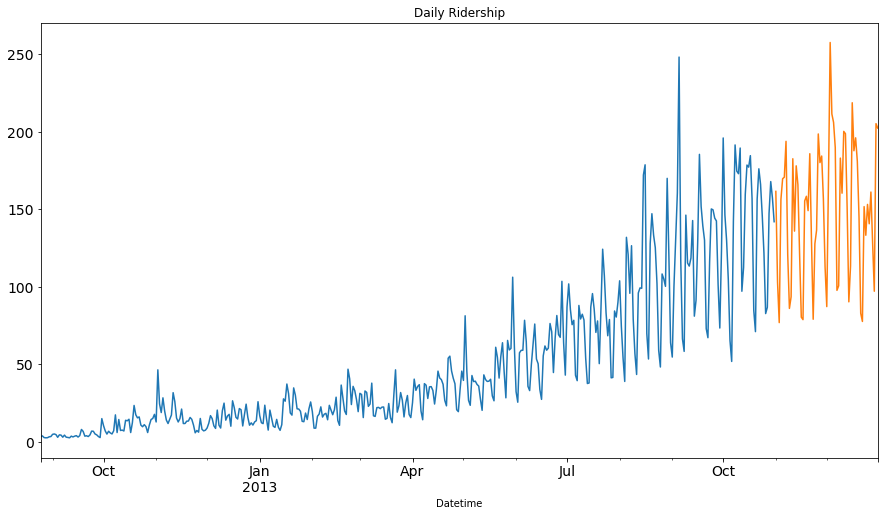

In [9]:
train.Count.plot(figsize=(15,8),title= 'Daily Ridership', fontsize=14)
test.Count.plot(figsize=(15,8),title= 'Daily Ridership', fontsize=14)

# Naive Approach

In [13]:
dd=np.asarray(train.Count)

In [15]:
y_hat=test.copy()

In [21]:
y_hat["naive"]=dd[len(dd)-1]

Text(0.5, 1.0, 'Naive Forecast')

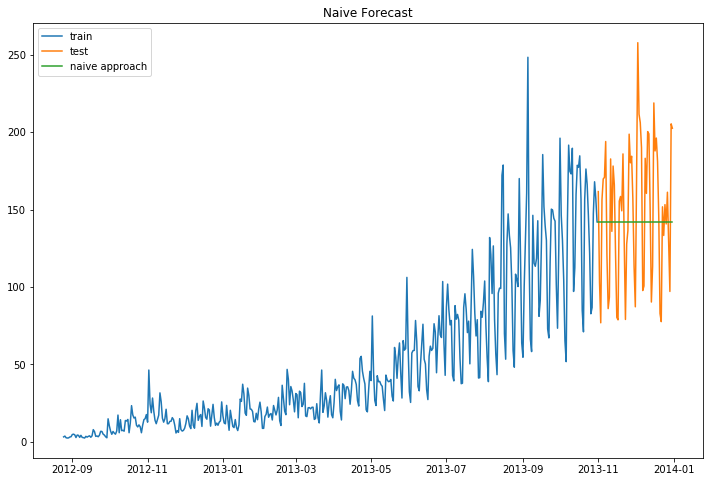

In [32]:
plt.figure(figsize=(12,8))

plt.plot(train.index,train["Count"],label="train")
plt.plot(test.index,test["Count"],label="test")
plt.plot(y_hat.index,y_hat["naive"],label="naive approach")

plt.legend(loc='best')
plt.title("Naive Forecast")


In [34]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.Count, y_hat.naive))
print(rms)

43.91640614391676


# Simple Average

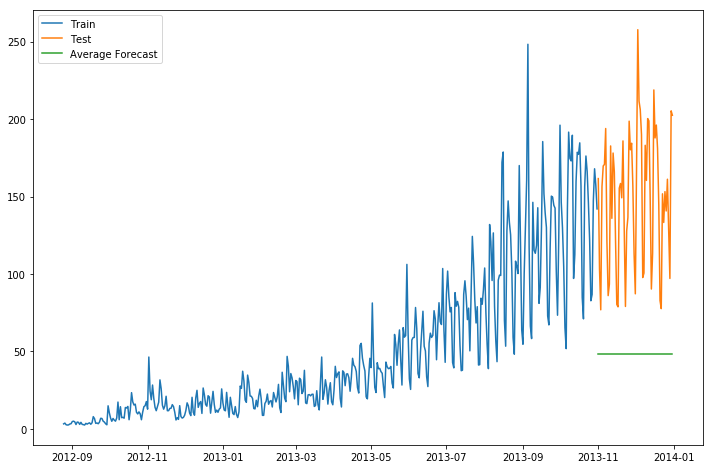

In [35]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Count'].mean()
plt.figure(figsize=(12,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [36]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.avg_forecast))
print(rms)

109.88526527082863


# Moving Average

In [38]:
y_hat_avg = test.copy()

In [41]:
train['Count'].rolling(60).mean().iloc[-1]

131.76111111111112

In [50]:
train.iloc[373:,1].mean()

131.7611111111111

In [51]:
y_hat_avg['moving_avg_forecast'] = train['Count'].rolling(60).mean().iloc[-1]

In [53]:
y_hat_avg.head(2)

,ID,Count,moving_avg_forecast
Datetime,,,
2013-11-01,10403.5,161.583333,131.761111
2013-11-02,10427.5,103.083333,131.761111


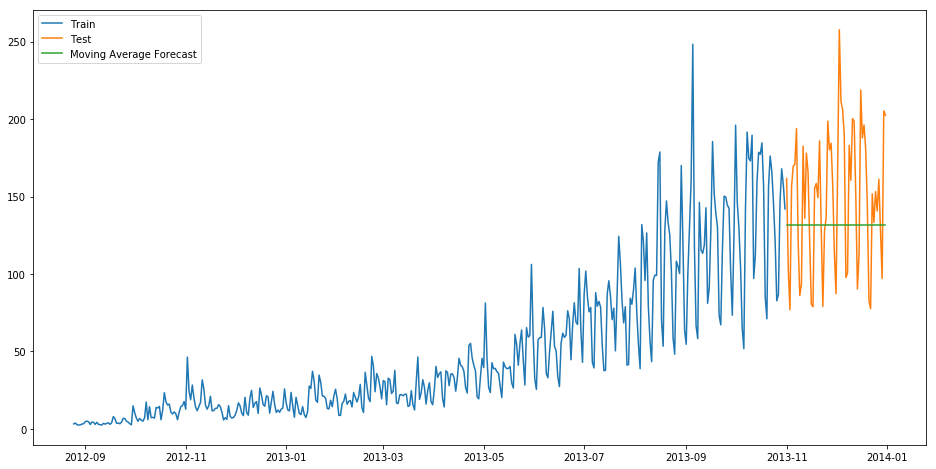

In [54]:
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [55]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.moving_avg_forecast))
print(rms)

46.72840725106963


# Simple Exponential Smoothing

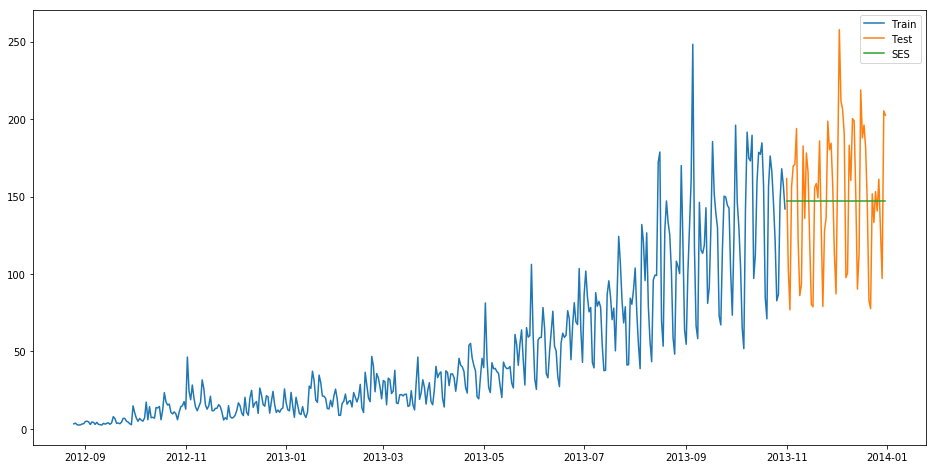

In [57]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Count'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()


In [58]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.SES))
print(rms)

43.357625225228155


# Holt’s Linear Trend method

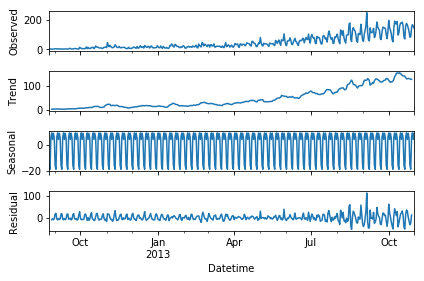

In [59]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(train.Count).plot()
result = sm.tsa.stattools.adfuller(train.Count)
plt.show()

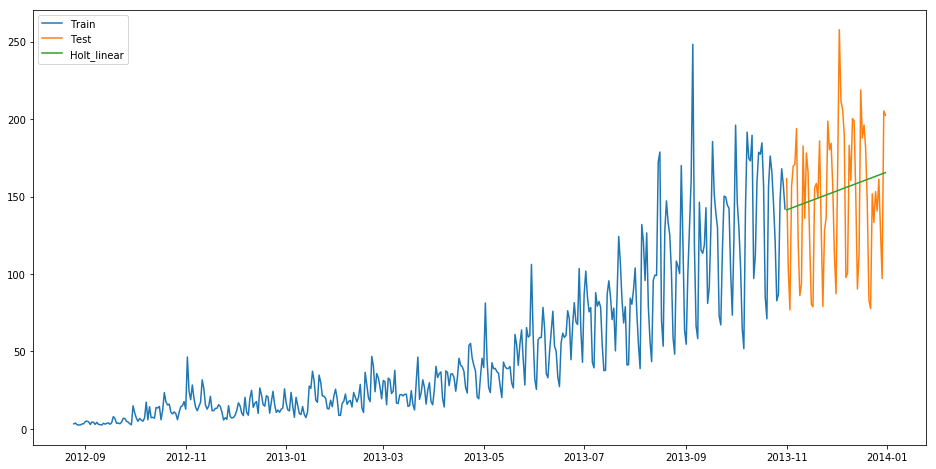

In [60]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['Count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [61]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.Holt_linear))
print(rms)

43.056259611507286


# Holt-Winters Method

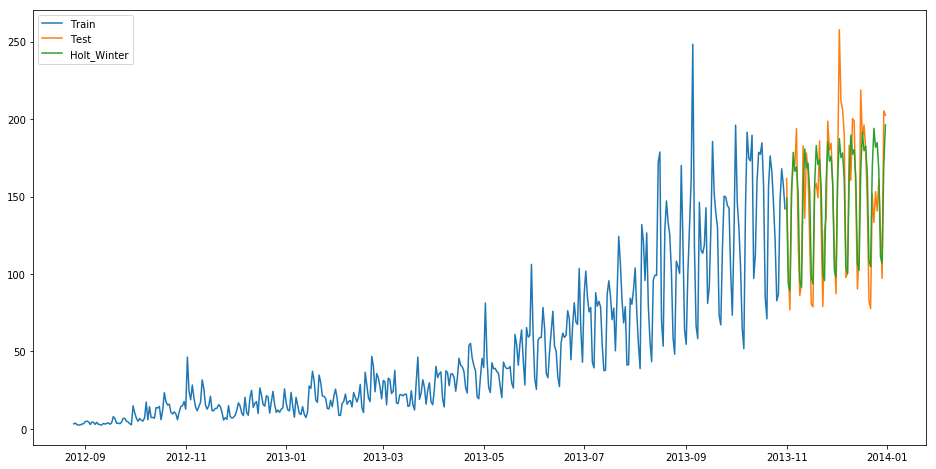

In [62]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()


In [63]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.Holt_Winter))
print(rms)


23.961492566159794


# Autoregressive Integrated Moving average

/home/anonymous/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


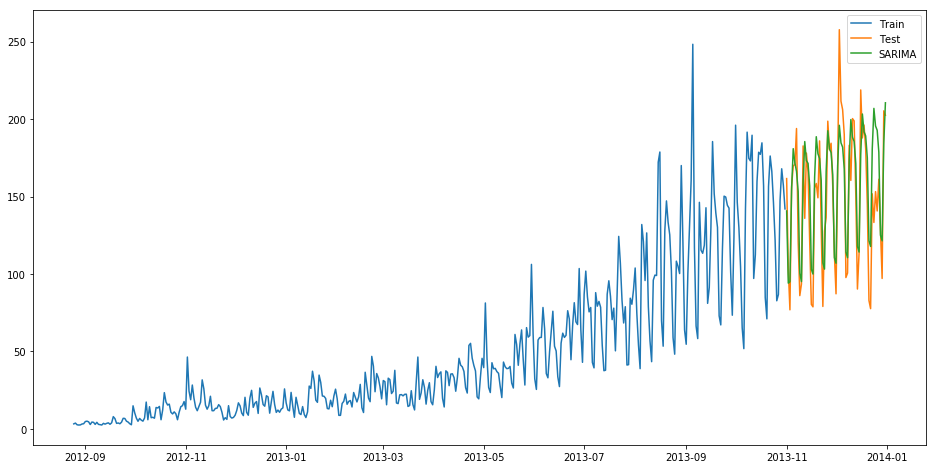

In [66]:
y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.Count, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2013-11-1", end="2013-12-31", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

In [67]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.SARIMA))
print(rms)

RMSE = 26.035582877

26.047734439097557


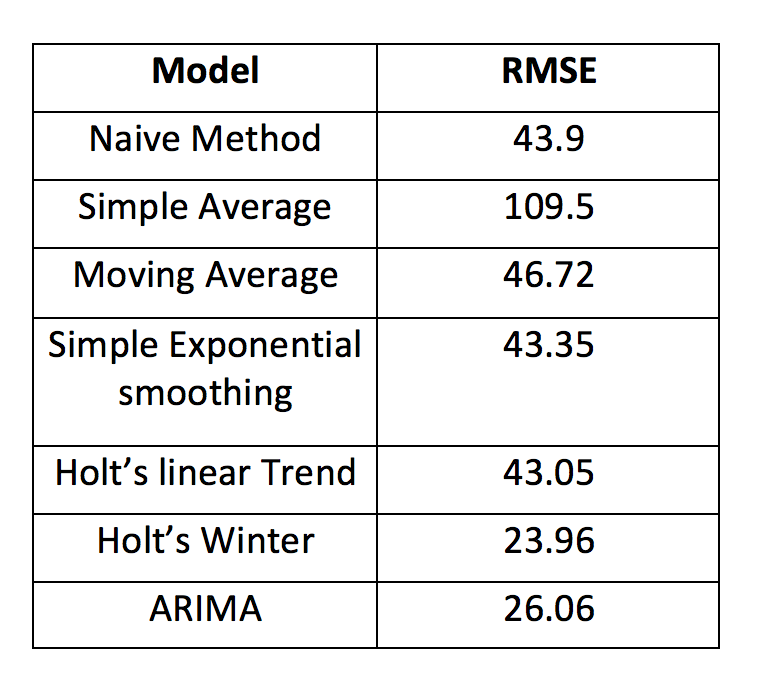